In [1]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od
dataset_url = 'https://www.kaggle.com/ikarus777/best-artworks-of-all-time'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: preetamp03
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time


100%|██████████| 2.29G/2.29G [01:14<00:00, 33.1MB/s]


In [2]:
data_dir = '/content/best-artworks-of-all-time/resized/'
import os
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))
from torchvision.datasets import ImageFolder
dataset = ImageFolder(data_dir)
len(dataset)

resized : 8683


8683

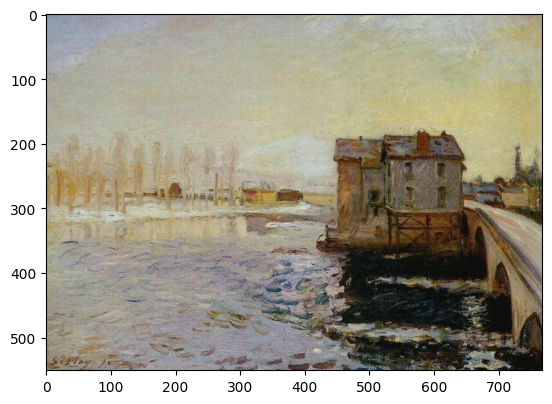

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
img, label = dataset[0]
plt.imshow(img)
img, label = dataset[500]
plt.imshow(img)
img, label = dataset[741]
plt.imshow(img)

In [4]:
import torchvision.transforms as tt
from torch.utils.data import DataLoader

image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
train_ds = ImageFolder(data_dir, transform=tt.Compose([
tt.Resize(image_size),
tt.CenterCrop(image_size),
tt.ToTensor(),
tt.Normalize(*stats)]))
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

from torchvision.utils import make_grid

def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):completed at 1:27 PM
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break
  show_batch(train_dl)

In [5]:
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)
  def __len__(self):
    """Number of batches"""
    return len(self.dl)

import torch

device = get_default_device()
device
train_dl = DeviceDataLoader(train_dl, device)

In [6]:
import torch.nn as nn
discriminator = nn.Sequential(
# in: 3 x 64 x 64
nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
nn.BatchNorm2d(64),
nn.LeakyReLU(0.2, inplace=True),
# out: 64 x 32 x 32
nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
nn.BatchNorm2d(128),
nn.LeakyReLU(0.2, inplace=True),
# out: 128 x 16 x 16
nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
nn.BatchNorm2d(256),
nn.LeakyReLU(0.2, inplace=True),
# out: 256 x 8 x 8
nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
nn.BatchNorm2d(512),
nn.LeakyReLU(0.2, inplace=True),
# out: 512 x 4 x 4
nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
# out: 1 x 1 x 1
nn.Flatten(),
nn.Sigmoid())
discriminator = to_device(discriminator, device)

In [7]:
latent_size = 128
generator = nn.Sequential(
# in: latent_size x 1 x 1
nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
nn.BatchNorm2d(512),
nn.ReLU(True),
# out: 512 x 4 x 4
nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
nn.BatchNorm2d(256),
nn.ReLU(True),
# out: 256 x 8 x 8
nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
nn.BatchNorm2d(128),
nn.ReLU(True),
# out: 128 x 16 x 16
nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
nn.BatchNorm2d(64),
nn.ReLU(True),
# out: 64 x 32 x 32
nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
nn.Tanh()
# out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


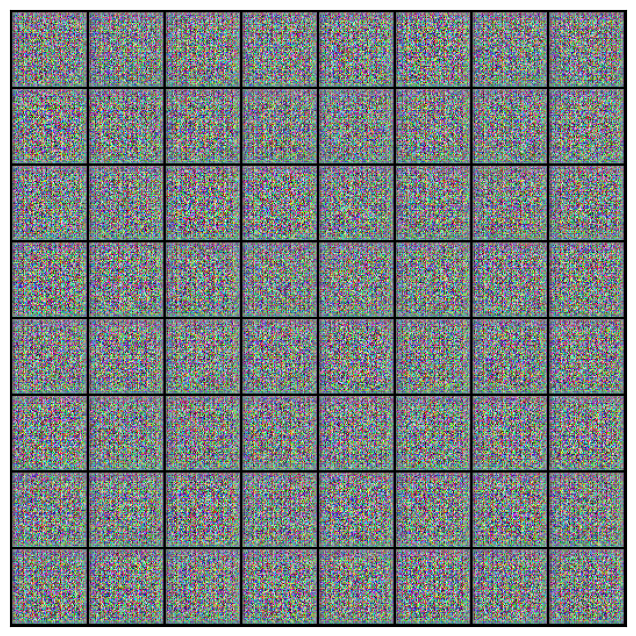

In [8]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [9]:
def train_discriminator(real_images, opt_d):
  # Clear discriminator gradients
  opt_d.zero_grad()
  # Pass real images through discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()
  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)
  # Pass fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()
  # Update discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

In [10]:
def train_generator(opt_g):
  # Clear generator gradients
  opt_g.zero_grad()
  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)
  # Try to fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)
  # Update generator weights
  loss.backward()
  opt_g.step()
  return loss.item()

from torchvision.utils import save_image

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print('Saving', fake_fname)
  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

  fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
  save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def fit(epochs, lr, start_idx=1):
  torch.cuda.empty_cache()

  # Losses & scores
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  # Create optimizers
  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  # Move models to the appropriate device
  discriminator.to(device) # Move discriminator to the device
  generator.to(device) # Move generator to the device

  fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)


  for epoch in range(epochs):

    for real_images, _ in tqdm(train_dl):
      # Train discriminator
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      # Train generator
      loss_g = train_generator(opt_g)
      # Record losses & scores
      losses_g.append(loss_g)
      losses_d.append(loss_d)
      real_scores.append(real_score)
      fake_scores.append(fake_score)

    # Log losses & scores (last batch)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
    epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

  # Save generated images
  save_samples(epoch+start_idx, fixed_latent, show=False)

  return losses_g, losses_d, real_scores, fake_scores

lr = 0.0002
epochs = 300
history = fit(epochs, lr)
losses_g, losses_d, real_scores, fake_scores = history
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
from IPython.display import Image

Image('./generated/generated-images-0001.png')

In [ ]:
Image('./generated/generated-images-0031.png')

In [ ]:
Image('./generated/generated-images-0090.png')

In [ ]:
Image('./generated/generated-images-0201.png')

In [ ]:
Image('./generated/generated-images-0300.png')

In [ ]:
import cv2
import os
vid_fname = 'art_gans_training.avi'
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()
out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 5, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()